# Технологии искусственного интеллекта. Семестр 1

© Петров М.В., старший преподаватель кафедры суперкомпьютеров и общей информатики, Самарский университет

## Лекция 4. Деревья решений

### Содержание

1. [Введение](#4.1-Введение)
2. [Определение решающего дерева](#4.2-Определение-решающего-дерева)
3. [Задача построения дерева](#4.3-Задача-построения-дерева)
4. [Жадный алгоритм построения решающего дерева](#4.4-Жадный-алгоритм-построения-решающего-дерева)
5. [Критерии ветвления: общая идея](#4.5-Критерии-ветвления:-общая-идея)
6. [Критерии ветвления для типичных задач](#4.6-Критерии-ветвления-для-типичных-задач)
7. [Особенности данных](#4.7-Особенности-данных)
8. [Методы регуляризации решающих деревьев](#4.8-Методы-регуляризации-решающих-деревьев)
9. [Пример](#4.9-Пример)
10. [Основные параметры дерева. `DecisionTreeClassifier`](#4.10-Основные-параметры-дерева.-DecisionTreeClassifier)
11. [Датасет `Rain in Australia`](#4.11-Датасет-Rain-in-Australia)
12. [Подготовка данных](#4.12-Подготовка-данных)
13. [Классификация](#4.13-Классификация)
14. [Ансамбли деревьев решений](#4.14-Ансамбли-деревьев-решений)
15. [Достоинства и недостатки деревьев решений](#4.15-Достоинства-и-недостатки-деревьев-решений)


### 4.1 Введение

Гайды:
- [Открытый курс машинного обучения. Тема 3. Классификация, деревья решений и метод ближайших соседей](https://habr.com/ru/companies/ods/articles/322534/)
- [Учебник по машинному обучению от ШАД. 2.3. Решающие деревья](https://academy.yandex.ru/handbook/ml/article/reshayushchiye-derevya)

Решающее дерево предсказывает значение целевой переменной путем применения последовательности простых решающих правил (которые называются *предикатами*). Этот процесс в некотором смысле согласуется с естественным для человека процессом принятия решений.

Начнём с небольшого примера. На картинке ниже изображено дерево, построенное для задачи классификации на пять классов:

<div align="center">
  <img src="images/trees_1.svg" width="481" title="Дерево решений"/>
  <p style="text-align: center">
    Рисунок 1 &ndash; Дерево решений
  </p>
</div>

Объекты в этом примере имеют два признака с вещественными значениями: $X$ и $Y$. Решение о том, к какому классу будет отнесён текущий объект выборки, будет приниматься путем прохода от корня дерева к некоторому листу.

В каждом узле этого дерева находится предикат. Если предикат верен для текущего примера из выборки, мы переходим в правого потомка, если нет &ndash; в левого. В данном примере все предикаты &ndash; это просто взятие порога по значению какого-то признака:
$$
B(x, j, t) = [x_j \leq t]
$$

На картинке ниже визуализирован процесс построения решающих поверхностей, порождаемых деревом (правая часть картинки):

<div align="center">
  <img src="images/trees_2.svg" width="859" title="Дерево решений и решающие поверхности"/>
  <p style="text-align: center">
    Рисунок 2 &ndash; Дерево решений и решающие поверхности
  </p>
</div>

Каждый предикат порождает разделение текущего подмножества пространства признаков на две части. На первом этапе, когда происходило деление по $[X \leq X_1]$, вся плоскость была поделена на две соответствующие части. На следующем уровне часть плоскости, для которой выполняется $[X \leq X_1]$, была поделена на две части по значению второго признака $[Y \leq Y_1]$ &ndash; так образовались области $1$ и $2$. То же самое повторяется для правой части дерева &ndash; и так далее до листовых вершин: получится $5$ областей на плоскости. Теперь любому объекту выборки будет присваиваться один из пяти классов в зависимости от того, в какую из образовавшихся областей он попадает.

### 4.2 Определение решающего дерева

Пусть задано бинарное дерево, в котором:
- каждой внутренней вершине $v$ приписан предикат $B_v : \mathbb{X} \to 0, 1$;
- каждой листовой вершине $v$ приписан прогноз $c_v \in \mathbb{Y}$, где $\mathbb{Y}$ &ndash; область значений целевой переменной (в случае классификации листу может быть также приписан вектор вероятностей классов).

В ходе предсказания осуществляется проход по этому дереву к некоторому листу. Для каждого объекта выборки $x$ движение начинается из корня. В очередной внутренней вершине $v$ проход продолжится вправо, если $B_v(x)=1$, и влево, если $B_v(x)=0$. Проход продолжается до момента, пока не будет достигнут некоторый лист, и ответом алгоритма на объекте $x$ считается прогноз $c_v$, приписанный этому листу.

Предикат $B_v$ может иметь, вообще говоря, произвольную структуру, но, как правило, на практике используют просто сравнение с порогом $t \in \mathbb{R}$ по какому-то $j$-му признаку:

$$
B(x, j, t) = [x_j \leq t]
$$

При проходе через узел дерева с данным предикатом объекты будут отправлены в правое поддерево, если значение $j$-го признака у них меньше либо равно $t$, и в левое &ndash; если больше.

Из структуры дерева решений следует несколько интересных свойств:
- Выученная функция является кусочно-постоянной, из-за чего производная равна нулю везде, где задана. Следовательно, о градиентных методах при поиске оптимального решения можно забыть.
- Дерево решений (в отличие от, например, линейной модели) не сможет экстраполировать зависимости за границы области значений обучающей выборки.
- Дерево решений способно идеально приблизить обучающую выборку и ничего не выучить (то есть такой классификатор будет обладать низкой обобщающей способностью): для этого достаточно построить такое дерево, в каждый лист которого будет попадать только один объект. Следовательно, при обучении нам надо не просто приближать обучающую выборку как можно лучше, но и стремиться оставлять дерево как можно более простым, чтобы результат обладал хорошей обобщающей способностью.

### 4.3 Задача построения дерева

Пусть, как обычно, у нас задан датасет $(X,y)$, где $y=\{y_i\}_{i=1}^N \subset \mathbb{R}^N$ &ndash; вектор таргетов, а $X=\{x_i\}_{i=1}^N \in \mathbb{R}^{N \times D}, x_i \in \mathbb{R}^D$ &ndash; матрица признаков, в которой $i$-я строка &ndash; это вектор признаков $i$-го объекта выборки. Пусть у нас также задана функция потерь $L(f, X, y)$, которую мы бы хотели минимизировать.

Наша задача &ndash; построить решающее дерево, наилучшим образом предсказывающее целевую зависимость. Однако, как уже было замечено выше, оптимизировать структуру дерева с помощью градиентного спуска не представляется возможным. Как ещё можно было бы решить эту задачу? Давайте начнём с простого &ndash; научимся строить *решающие пни*, то есть решающие деревья глубины $1$.

Как и раньше, мы будем рассматривать только самые простые предикаты:

$$
B_{j,t}(x_i) = [x_{ij} \leq t]
$$

Ясно, что задачу можно решить полным перебором: существует не более $(N-1)D$ предикатов такого вида. Действительно, индекс $j$ (номер признака) пробегает значения от $1$ до $D$, а всего значений порога $t$, при которых меняется значение предиката, может быть не более $N-1$:

<div align="center">
  <img src="images/trees_3.svg" width="501" title="Предикаты"/>
  <p style="text-align: center">
    Рисунок 3 &ndash; Предикаты
  </p>
</div>

Решение, которое мы ищем, будет иметь вид:

$$
(j_{opt}, t_{opt}) = \argmin_{j,t} L(B_{j,t}, X, y)
$$

Для каждого из предикатов $B_{j,t}$ нам нужно посчитать значение функции потерь на всей выборке, что, в свою очередь, тоже занимает $O(N)$. Следовательно, полный алгоритм выглядит так:

```python
min_loss = inf
optimal_border = None

for j in range(D):
    for t in X[:, j]:  # Можно брать сами значения признаков в качестве порогов
        loss = calculate_loss(t, j, X, y)
        if loss < min_loss:
           min_loss, optimal_border = loss, (j, t)
```

Сложность алгоритма &ndash; $O(N^2D)$. Это не заоблачная сложность, хотя, конечно, не идеальная. Но это была схема возможного алгоритма поиска оптимального дерева высоты $1$.

Как обобщить алгоритм для дерева произвольной глубины? Мы можем сделать наш алгоритм поиска решающего пня рекурсивным и в теле цикла вызывать исходную функцию для всех возможных разбиений. Как мы упоминали выше, так можно построить дерево, идеально запоминающее всю выборку, однако на тестовых данных такой алгоритм вряд ли покажет высокое качество. Можно поставить другую задачу: построить оптимальное с точки зрения качества на обучающей выборке дерево минимальной глубины (чтобы снизить переобучение). Проблема в том, что поиск такого дерева является $NP$-полной задачей, то есть человечеству пока неизвестны способы решить её за полиномиальное время.

Как быть? Идеального ответа на этот вопрос нет, но до некоторой степени ситуацию можно улучшить двумя не исключающими друг друга способами:
1. Разрешить себе искать не оптимальное решение, а просто достаточно хорошее. Начать можно с того, чтобы строить дерево с помощью жадного алгоритма, то есть не искать всю структуру сразу, а строить дерево этаж за этажом. Тогда в каждой внутренней вершине дерева будет решаться задача, схожая с задачей построения решающего пня. Для того чтобы этот подход хоть как-то работал, его придётся прокачать внушительным набором эвристик.
2. Заняться оптимизацией с точки зрения *computer science* &ndash; наивную версию алгоритма (перебор наборов возможных предикатов и порогов) можно ускорить и асимптотически, и в константу раз.

### 4.4 Жадный алгоритм построения решающего дерева

Пусть $X$ &ndash; исходное множество объектов обучающей выборки, а $X_m$ &ndash; множество объектов, попавших в текущий лист (в самом начале $X_m=X$). Тогда жадный алгоритм можно верхнеуровнево описать следующим образом:
1. Создаём вершину $v$.
2. Если выполнен критерий остановки $Stop(X_m)$, то останавливаемся, объявляем эту вершину листом и ставим ей в соответствие ответ $Ans(X_m)$, после чего возвращаем её.
3. Иначе: находим предикат (иногда ещё говорят сплит) $B_{j,t}$, который определит наилучшее разбиение текущего множества объектов $X_m$ на две подвыборки $X_l$ и $X_r$, максимизируя критерий ветвления $Branch(X_m, j, t)$.
4. Для $X_l$ и $X_r$ рекурсивно повторим процедуру.

Данный алгоритм содержит в себе несколько вспомогательных функций, которые надо выбрать так, чтобы итоговое дерево было способно минимизировать $L$:
- $Ans(X_m)$, вычисляющая ответ для листа по попавшим в него объектам из обучающей выборки, может быть, например:
  - В случае задачи классификации &ndash; меткой самого частого класса или оценкой дискретного распределения вероятностей классов для объектов, попавших в этот лист.
  - В случае задачи регрессии &ndash; средним, медианой или другой статистикой.
  - Простой моделью. К примеру, листы в дереве, задающем регрессию, могут быть линейными функциями или синусоидами, обученными на данных, попавших в лист. Впрочем, везде ниже мы будем предполагать, что в каждом листе просто предсказывается константа.
- Критерий остановки $Stop(X_m)$ &ndash; функция, которая решает, нужно ли продолжать ветвление или пора остановиться.
  Это может быть какое-то тривиальное правило: например, остановиться только в тот момент, когда объекты в листе получились достаточно однородными и/или их не слишком много.
- Критерий ветвления $Branch(X_m, j, t)$ &ndash; пожалуй, самая интересная компонента алгоритма. Это функция, измеряющая, насколько хорош предлагаемый сплит. Чаще всего эта функция оценивает, насколько улучшится некоторая финальная метрика качества дерева в случае, если получившиеся два листа будут терминальными, по сравнению с ситуацией, когда сама исходная вершина является листом. Выбирается такой сплит, который даёт наиболее существенное улучшение.

При этом строгой теории, которая бы связывала оптимальность выбора разных вариантов этих функций и разных метрик классификации и регрессии, в общем случае не существует.

### 4.5 Критерии ветвления: общая идея

Давайте теперь по очереди посмотрим на популярные постановки задач ML и под каждую подберём свой критерий.

Ответы дерева будем кодировать так: $c \in \mathbb{R}$ &ndash; для ответов регрессии и меток класса; для случаев, когда надо ответить дискретным распределением на классах, $c \in \mathbb{R}^K$ будет вектором вероятностей:

$$
c = c(c_1, \dots, c_K), \displaystyle\sum_{i=1}^{K} c_i = 1
$$

Предположим также, что задана некоторая функция потерь $L(y_i, c)$.

В момент, когда мы ищем оптимальный сплит $X_l \sqcup X_r$ ($A_1 \sqcup A_2 = \{(a,1) \mid a \in A_1\} \cup \{(a,2) \mid a \in A_2\}$), мы можем вычислить для объектов из $X_m$ тот константный таргет $c$, которые предсказало бы дерево, будь текущая вершина терминальной, и связанное с ними значение исходного функционала качества $L$. А именно &ndash; константа $c$ должна минимизировать среднее значение функции потерь:

$$
H(X_m) = \frac{1}{|X_m|} \displaystyle\sum_{(x_i, y_i) \in X_m} L(y_i,c)
$$

Оптимальное значение этой величины

$$
\underset{c \in Y}{\min} \frac{1}{|X_m|} \displaystyle\sum_{(x_i, y_i) \in X_m} L(y_i,c)
$$

обычно называют *информативностью*, или *impurity*. Чем она ниже, тем лучше объекты в листе можно приблизить константным значением.

Похожим образом можно определить информативность решающего пня. Пусть, как и выше, $X_l$ &ndash; множество объектов, попавших в левую вершину, а $X_r$ &ndash; в правую; пусть также $c_l$ и $c_r$ &ndash; константы, которые предсказываются в этих вершинах. Тогда функция потерь для всего пня в целом будет равна:

$$
\frac{1}{|X_m|} \left( \displaystyle\sum_{x_i \in X_l}{L(y_i,c_l)} + \displaystyle\sum_{x_i \in X_r}{L(y_i,c_r)} \right) =
\frac{1}{|X_m|} \left(|X_l| \cdot \frac{1}{|X_l|} \displaystyle\sum_{x_i \in X_l}{L(y_i,c_l)} + |X_r| \cdot \frac{1}{|X_r|} \displaystyle\sum_{x_i \in X_r}{L(y_i,c_r)} \right)
$$

Эта сумма будет минимальна при оптимальном выборе констант $c_l$ и $c_r$, и информативность пня будет равна:

$$
\frac{|X_l|}{|X_m|} H(X_l) + \frac{|X_r|}{|X_m|} H(X_r)
$$

Теперь для того чтобы принять решение о разделении, мы можем сравнить значение информативности для исходного листа и для получившегося после разделения решающего пня.

Разность информативности исходной вершины и решающего пня равна:

$$
H(X_m) - \frac{|X_l|}{|X_m|} H(X_l) - \frac{|X_r|}{|X_m|} H(X_r)
$$

Для симметрии её приятно умножить на $|X_m|$, тогда получится следующий критерий ветвления:

$$
Branch(X_m, j, t) = |X_m| \cdot H(X_m) - |X_l| \cdot H(X_l) - |X_r| \cdot H(X_r)
$$

Получившаяся величина неотрицательна: ведь, разделив объекты на две кучки и подобрав ответ для каждой, мы точно не сделаем хуже. Кроме того, она тем больше, чем лучше предлагаемый сплит.

Теперь посмотрим, какими будут критерии ветвления для типичных задач.

### 4.6 Критерии ветвления для типичных задач
#### Информативность в задаче регрессии: $MSE$

Посмотрим на простой пример &ndash; регрессию с минимизацией среднеквадратичной ошибки:

$$
L(y_i, c) = (y_i - c)^2
$$

Информативность листа будет выглядеть следующим образом:

$$
H(X_m) = \frac{1}{|X_m|} \underset{c \in Y}{\min} {\displaystyle\sum_{(x_i, y_i) \in X_m} (y_i - c)^2}
$$

Оптимальным предсказанием константного классификатора для задачи минимизации $MSE$ является среднее значение, то есть:

$$
c = \frac{\displaystyle\sum{y_i}}{|X_m|}
$$

Подставив в формулу информативности сплита, получаем:

$$
H(X_m) = \displaystyle\sum_{(x_i, y_i) \in X_m}{\frac{(y_i - \overline{y})^2}{|X_m|}} \text{, где } \overline{y} = \frac{1}{|X_m|} \displaystyle\sum_i y_i
$$

То есть при жадной минимизации $MSE$ информативность &ndash; это оценка дисперсии таргетов для объектов, попавших в лист. Получается очень стройная картинка: оценка значения в каждом листе &ndash; это среднее, а выбирать сплиты надо так, чтобы сумма дисперсий в листьях была как можно меньше.

#### Информативность в задаче регрессии: $MAE$

$$
L(y_i, c) = |y_i - c|
$$

Случай средней абсолютной ошибки так же прост: в листе надо предсказывать медиану, ведь именно медиана таргетов для обучающих примеров минимизирует $MAE$ констатного предсказателя.

В качестве информативности выступает абсолютное отклонение от медианы:

$$
H(X_m) = \displaystyle\sum_{(x_i, y_i) \in X_m} \frac{y_i - median(Y)}{|X_m|}
$$

#### Критерий информативности в задаче классификации: $\textit{misclassification error}$

Пусть в нашей задаче $K$ классов, а $p_k$ &ndash; доля объектов класса $k$ в текущей вершине $X_m$:

$$
p_k = \frac{1}{|X_m|} \displaystyle\sum_{(x_i, y_i) \in X_m} \mathbb{I}[y_i = k]
$$

Допустим, мы заботимся о доле верно угаданных классов, то есть функция потерь &ndash; это индикатор ошибки:

$$
L(y_i, c) = \mathbb{I}[y_i \neq c]
$$

Пусть также предсказание модели в листе &ndash; один какой-то класс. Информативность для такой функции потерь выглядит так:

$$
H(X_m) = \underset{c \in Y}{\min} {\frac{1}{|X_m|} \displaystyle\sum_{(x_i, y_i) \in X_m} \mathbb{I}[y_i \neq c]}
$$

Ясно, что оптимальным предсказанием в листе будет наиболее частотный класс $k_*$, а выражение для информативности упростится следующим образом:

$$
H(X_m) = \frac{1}{|X_m|} \displaystyle\sum_{(x_i, y_i) \in X_m} {\mathbb{I}[y_i \neq k_*]} = 1 - p_{k_*}
$$

#### Информативность в задаче классификации: энтропия

Если же мы собрались предсказывать вероятностное распределение классов $(c_1, \cdots, c_K)$, то к этому вопросу можно подойти через максимизацию логарифма правдоподобия (== минимизацию минус логарифма) распределения Бернулли. А именно, пусть в вершине дерева предсказывается фиксированное распределение $c$ (не зависящее от $x_i$), тогда правдоподобие имеет вид:

$$
P(y \mid x, c) = P(y \mid c) = \prod_{(x_i, y_i) \in X_m} P(y_i \mid c) = \prod_{(x_i, y_i) \in X_m} {\prod_{k=1}^K c_k^{\mathbb{I}[y_i = k]}}
$$

откуда

$$
H(X_m) = \underset{ \displaystyle\sum_k{c_k} = 1 }{\min} {\left( - \frac{1}{|X_m|} \displaystyle\sum_{(x_i, y_i) \in X_m}{ \displaystyle\sum_{k=1}^{K}{\mathbb{I}[y_i = k] \log c_k}} \right)}
$$

То, что оценка вероятностей в листе $c_k$, минимизирующая $H(X_m)$, должна быть равна $p_k$, то есть доле попавших в лист объектов этого класса, до некоторой степени очевидно.

Подставляя вектор $c = (p_1, \dots, p_K)$ в выражение выше, мы в качестве информативности получим энтропию распределения классов:

$$
H(X_m) = - \displaystyle\sum_{k=1}^K {p_k \log p_k}
$$

#### Информативность в задаче классификации: критерий Джини

Пусть предсказание модели &ndash; это распределение вероятностей классов $(c_1, \dots, c_k)$. Вместо логарифма правдоподобия в качестве критерия можно выбрать, например, метрику Бриера (за которой стоит всего лишь идея посчитать $MSE$ от вероятностей). Тогда информативность получится равной:

$$
H(X_m) = \underset{ \displaystyle\sum_k{c_k} = 1 }{\min} {\frac{1}{|X_m|} \displaystyle\sum_{(x_i, y_i) \in X_m}{ \displaystyle\sum_{k=1}^{K}{(c_k - \mathbb{I}[y_i = k])^2}} }
$$

Можно показать, что оптимальное значение этой метрики, как и в случае энтропии, достигается на векторе $c$, состоящем из выборочных оценок частот классов: $(p_1, \dots, p_k)$,
$$
p_i = \frac{1}{|X_m|} \displaystyle\sum_{i}{\mathbb{I}[y_i = k]}.
$$

Если подставить $(p_1, \dots, p_k)$ в выражение выше и упростить его, получится критерий Джини:

$$
H(X_m) = \displaystyle\sum_{k=1}^K {p_k (1 - p_k)}
$$

Критерий Джини допускает и следующую интерпретацию: $H(X_m)$ равно математическому ожиданию числа неправильно классифицированных объектов в случае, если мы будем приписывать им случайные метки из дискретного распределения, заданного вероятностями $(p_1, \dots, p_k)$.

### 4.7 Особенности данных

#### Категориальные признаки

На первый взгляд, деревья прекрасно могут работать с категориальными переменными. А именно, если признак $x^i$ принимает значения из множества $C = \{c_1, \dots, c_M\}$, то при очередном разбиении мы можем рассматривать по этому признаку произвольные сплиты вида $C = C_l \sqcup C_r$ (предикат будет иметь вид $[x^i \in C_r]$). Это очень логично и естественно? Проблема в том, что при больших $M$ у нас будет $2^{M-1} - 1$ сплитов, и перебирать их будет слишком долго. Было бы здорово уметь каким-то образом *упорядочивать* значения $c_m$, чтобы работать с ними так же, как с обычными числами: разделяя на значения, «не превосходящие» и «большие» определённого порога.

Оказывается, что для некоторых задач такое упорядочение можно построить вполне естественным образом.

Так, для задачи *бинарной классификации* значения $c_m$ можно упорядочить по неубыванию доли объектов класса $1$ с $x^i = c_m$, после чего работать с ними, как со значениями вещественного признака. Показано, что в случае, если мы выбираем таким образом сплит, оптимальный с точки зрения энтропийного критерия или критерия Джини, то он будет оптимальным среди всех $2^{M-1} - 1$ сплитов.

Для задачи *регрессии* с функцией потерь $MSE$ значения $c_m$ можно упорядочивать по среднему значению таргета на подмножестве $\{X \mid x^i = c_m\}$. Полученный таким образом сплит тоже будет оптимальным.

#### Работа с пропусками

Одна из приятных особенностей деревьев &ndash; это способность обрабатывать пропуски в данных. Разберёмся, что при этом происходит на этапе обучения и на этапе применения дерева.

Пусть у нас есть некоторый признак $x^i$, значение которого пропущено у некоторых объектов. Как обычно, обозначим через $X_m$ множество объектов, пришедших в рассматриваемую вершину, а через $V_m$ &ndash; подмножество $X_m$, состоящее из объектов с пропущенным значением $x^i$. В момент выбора сплитов по этому признаку мы будет просто игнорировать объекты из $V_m$, а когда сплит выбран, мы отправим их в оба поддерева. При этом логично присвоить им веса:

$$
\frac{|X_l|}{|X_m|} \text{ - для левого поддерева}, \frac{|X_r|}{|X_m|} \text{ - для правого поддерева}.
$$

Веса будут учитываться как коэффициенты при $L(y_i, c)$ в формуле информативности.

Теперь рассмотрим этап применения дерева. Допустим, в вершину, где сплит идёт по $i$-му признаку, пришёл объект $x_0$ с пропущенным значением этого признака. Предлагается отправить его в каждую из дальнейших веток и получить по ним предсказания $\hat{y}_l$ и $\hat{y}_r$. Эти предсказания мы усредним с весами
$$
\frac{|X_l|}{|X_m|}, \frac{|X_r|}{|X_m|}
$$

(которые мы запомнили в ходе обучения):

$$
\hat{y} = \frac{|X_l|}{|X_m|} \hat{y}_l + \frac{|X_r|}{|X_m|} \hat{y}_r.
$$

Для задачи *регрессии* это сразу даст нам таргет, а в задаче *бинарной классификации* &ndash; оценку вероятности класса $1$.

> Если речь идёт о категориальном признаке, может оказаться хорошей идеей ввести дополнительное значение «пропущено» для категориального признака и дальше работать с пропусками, как с обычным значением. Особенно это актуально в ситуациях, когда пропуски имеют системный характер и их наличие несёт в себе определённую информацию.

### 4.8 Методы регуляризации решающих деревьев
Мы уже упоминали выше, что деревья легко переобучаются и процесс ветвления надо в какой-то момент останавливать.

Для этого есть разные критерии, обычно используются все сразу:

- ограничение по максимальной глубине дерева;
- ограничение на минимальное количество объектов в листе;
- ограничение на максимальное количество листьев в дереве;
- требование, чтобы функционал качества $Branch$ при делении текущей подвыборки на две улучшался не менее чем на $s$ процентов.

Делать это можно на разных этапах работы алгоритма, что не меняет сути, но имеет разные устоявшиеся названия:
- Можно проверять критерии прямо во время построения дерева, такой способ называется *pre-pruning* или *early stopping*.
- А можно построить дерево жадно без ограничений, а затем провести стрижку (*pruning*), то есть удалить некоторые вершины из дерева так, чтобы итоговое качество упало не сильно, но дерево начало подходить под условия регуляризации. При этом качество стоит измерять на отдельной, отложенной выборке.

### 4.9 Пример

Рассмотрим пример применения дерева решений из библиотеки `scikit-learn` для синтетических данных. Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

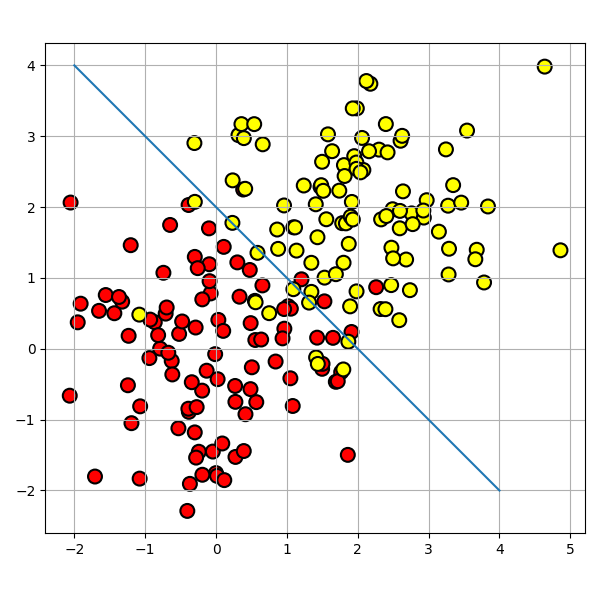

In [1]:
import numpy as np
%matplotlib inline
%matplotlib widget
from ipywidgets import *
import matplotlib.pyplot as plt

# Сгенерируем данные

# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=[2,2])]
train_labels = np.r_[train_labels, np.ones(100)]

# Отобразим данные
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100,
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1))
plt.grid()
plt.tight_layout()
ax.set_aspect('equal', adjustable='box')

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр `max_depth`, ограничивающий глубину дерева. Визуализируем полученную границу разделения класссов.

In [2]:
# Вспомогательная функция, которая будет возвращать решетку для дальнейшей красивой визуализации
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid( np.arange(x_min, x_max, eps), np.arange(y_min, y_max, eps) )

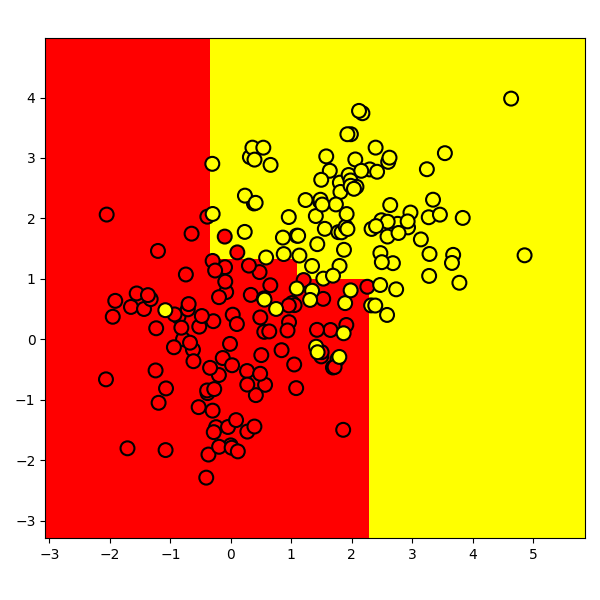

In [3]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
# Создаём объект модели
clf_tree = DecisionTreeClassifier(
    criterion = 'entropy', max_depth = 3, random_state = 17
)

# обучаем дерево
clf_tree.fit( train_data, train_labels )

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid( train_data )
predicted = clf_tree.predict( np.c_[xx.ravel(), yy.ravel()] ).reshape( xx.shape )
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['axes.grid'] = False
plt.pcolormesh( xx, yy, predicted, cmap = 'autumn' )
ax.scatter( train_data[:, 0], train_data[:, 1], c=train_labels, s = 100,
             cmap = 'autumn', edgecolors = 'black', linewidth = 1.5 );
plt.tight_layout()
ax.set_aspect('equal', adjustable='box')

А как выглядит само построенное дерево? Видим, что дерево "нарезает" пространство на 7 прямоугольников (в дереве 7 листьев). В каждом таком прямоугольнике прогноз дерева будет константным, по превалированию объектов того или иного класса.

In [4]:
from pathlib import Path
# путь к папке с данными
data_path = "./images/"

# используем .dot формат для визуализации дерева
sklearn.tree.export_graphviz(
    clf_tree,
    feature_names = ['x1', 'x2'],
    out_file = f'{data_path}/small_tree.dot',
    filled = True
)

# для выполнения следующей команды нужен установленный GraphViz
!dot -Tpng ./images/small_tree.dot -o ./images/small_tree.png

<div align="center">
  <img src="images/small_tree.png" title="Визуализация дерева решений"/>
  <p style="text-align: center">
    Рисунок 4 &ndash; Визуализация дерева решений
  </p>
</div>

Как "читается" такое дерево?

Сначала было 200 объектов, 100 &ndash; одного класса и 100 &ndash; другого. Энтропия начального состояния была максимальной – $1$. Затем было сделано разбиение объектов на 2 группы в зависимости от сравнения признака $x_1$ со значением $1.103$ (найдите этот участок границы на рисунке выше, до дерева). При этом энтропия и в левой, и в правой группе объектов уменьшилась. И так далее, дерево строится до глубины $3$. При такой визуализации чем больше объектов одного класса, тем цвет вершины ближе к темно-оранжевому и, наоборот, чем больше объектов второго класса, тем ближе цвет к темно-синему. В самом начале объектов одного класса поровну, поэтому корневая вершина дерева &ndash; белого цвета.

#### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак.

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:

In [5]:
import pandas as pd

data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33],
                     'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})
data

,Возраст,Невозврат кредита
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [6]:
# Отсортируем по возрастанию возраста
data.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


Обучим на этих данных дерево решений (без ограничения глубины) и посмотрим на него.

In [7]:
age_tree = DecisionTreeClassifier(random_state = 17)
age_tree.fit(data['Возраст'].values.reshape(-1, 1), data['Невозврат кредита'].values)

# Отрисуем дерево
sklearn.tree.export_graphviz(
    age_tree, feature_names=['Возраст'],
    out_file = f'{data_path}/age_tree.dot', filled = True
)
!dot -Tpng ./images/age_tree.dot -o ./images/age_tree.png

<div align="center">
  <img src="images/age_tree.png" title="Визуализация дерева решений"/>
  <p style="text-align: center">
    Рисунок 5 &ndash; Визуализация дерева решений
  </p>
</div>

Видим, что дерево задействовало 5 значений, с которыми сравнивается возраст: $43.5$, $19$, $22.5$, $30$ и $32$ года. Если приглядеться, то это аккурат средние значения между возрастами, при которых целевой класс "меняется" с $1$ на $0$ или наоборот. Сложная фраза, поэтому пример: $43.5$ &ndash; это среднее между $38$ и $49$ годами, клиент, которому $38$ лет, не вернул кредит, а тот, которому $49$ &ndash; вернул. Аналогично, $19$ лет &ndash; среднее между $18$ и $20$ годами. То есть в качестве порогов для "нарезания" количественного признака, дерево "смотрит" на те значения, при которых целевой класс меняет свое значение.

### 4.10 Основные параметры дерева. `DecisionTreeClassifier`

В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается из-за того, что такое дерево будет переобученным &ndash; оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине, будут появляться разбиения по менее важным признакам (например, приехал ли клиент из Саратова или Костромы). Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит. Но мы не хотим, чтобы наша модель классификации порождала такие специфичные правила.

Основные способы борьбы с переобучением в случае деревьев решений:
- Искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается.
- Стрижка дерева (pruning). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него (сравнение проводится с помощью кросс-валидации).

#### Класс DecisionTreeClassifier в `scikit-learn`

Основные параметры класса [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):
- `max_depth` &ndash; максимальная глубина дерева.
- `max_features` &ndash; максимальное число признаков, по которым ищется лучшее разбиение в дереве. При большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков.
- `min_samples_leaf` &ndash; минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен $5$, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для $5$ объектов.

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с использованием кросс-валидации.

### 4.11 Датасет `Rain in Australia`

Датасет содержит данные о метеонаблюдениях в Австралии, цель - прогнозирование дождя на следующий день. Целевой признак - `RainTomorrow`.

| Column        | Meaning                                                                                                | Units               |
|---------------|--------------------------------------------------------------------------------------------------------|---------------------|
| Location      | The common name of the location of the weather station                                                 |                     |
| MinTemp       | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree.          | degrees Celsius     |
| MaxTemp       | Maximum temperature in the 24 hours from 9am. Sometimes only known to the nearest whole degree.        | degrees Celsius     |
| Rainfall      | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimetre. | millimetres         |
| Sunshine      | Bright sunshine in the 24 hours to midnight                                                            | hours               |
| WindGustDir   | Direction of strongest gust in the 24 hours to midnight                                                | 16 compass points   |
| WindGustSpeed | Speed of strongest wind gust in the 24 hours to midnight                                               | kilometres per hour |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9 am                                                  | compass points      |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3 pm                                                  | compass points      |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9 am                                                      | kilometres per hour |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3 pm                                                      | kilometres per hour |
| Humidity9am   | Relative humidity at 9 am                                                                              | percent             |
| Humidity3pm   | Relative humidity at 3 pm                                                                              | percent             |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9 am                                                 | hectopascals        |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3 pm                                                 | hectopascals        |
| Cloud9am      | Fraction of sky obscured by cloud at 9 am                                                              | eighths             |
| Cloud3pm      | Fraction of sky obscured by cloud at 3 pm                                                              | eighths             |
| Temp9am       | Temperature at 9 am                                                                                    | degrees Celsius     |
| Temp3pm       | Temperature at 3 pm                                                                                    | degrees Celsius     |
| RainToday     | The rain for that day was 1mm or more                                                                  | Yes or No           |
| RainTomorrow  | The rain for that day was 1mm or more. The target variable to predict.                                 | Yes or No           |

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
# путь к папке с данными
data_path = "../lecture_3/data"
# датасет: Rain in Australia: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
df = pd.read_csv(Path(data_path, 'weatherAUS.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### 4.12 Подготовка данных

Более подробно процедуры предобработки данных описаны в [лекции](../lecture_3/lecture_3.ipynb).

In [9]:
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler

# Drop NaN in RainTomorrow
df = df.drop(df[df['RainTomorrow'].isna()].index)
# Cat cols
cat_cols = [var for var in df.columns if df[var].dtype == 'object']
cat_null = df[cat_cols].isnull().sum()
cat_null_mode = df[cat_null[cat_null > 0].index].mode()
print(f"Cat cols with NaNs mode: {cat_null_mode}")
# Fill NaNs
for col in cat_cols:
    df.fillna({col: df[col].mode()[0]}, inplace=True)
# Print cat cols cardinality
len_max = max([len(col) for col in cat_cols])
for col in cat_cols:
    print(f"{col:<{len_max}} labels: {len(df[col].unique())}")
# Split Date into Day, Month, Year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace = True)
cat_cols.remove('Date')
# Num cols
num_cols = [var for var in df.columns if not df[var].dtype == 'object']
# Fill NaNs
for col in num_cols:
    df.fillna({col: df[col].median()}, inplace=True)
# Encode Location
df_loc_dummy = pd.get_dummies(df.Location, prefix='Location')
df = df.drop('Location', axis = 1)
df = df.join(df_loc_dummy)
# Cat cols left
cat_left = [var for var in df.columns if df[var].dtype == 'object']
cat_left = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
# Encode cat cols
df = pd.get_dummies(data=df, columns=cat_left, drop_first=False)
# Replace values
df.replace({'RainToday': {'No': '0', 'Yes': '1'}}, inplace = True)
df.replace({'RainTomorrow': {'No': '0', 'Yes': '1'}}, inplace = True)
df['RainToday'] = df['RainToday'].astype(int)
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

num_cols_ext = deepcopy(num_cols)
num_cols_ext.append('RainToday')
# Scale data
all_cols = list(df.columns)
mm_scaler = MinMaxScaler()
features_scaled = mm_scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(features_scaled, columns=all_cols)

# Outliers bounds
def get_bounds(dataframe, col):
    iqr = dataframe[col].quantile(0.75) - dataframe[col].quantile(0.25)
    lower_bound = dataframe[col].quantile(0.25) - 1.5 * iqr
    upper_bound = dataframe[col].quantile(0.75) + 1.5 * iqr
    return lower_bound, upper_bound

num_cols_clean = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

bounds_dict = dict()

for col in num_cols_clean:
    lb, ub = get_bounds(df_scaled, col)
    bounds_dict[col] = [lb, ub]
    print(f"{col:<13} outliers are values < {lb:.2f} or > {ub:.2f}")

# Clean outliers
def clean_data(df, bounds_dict: dict):
    df_clean = deepcopy(df)
    print(df_clean.shape)

    for k, v in bounds_dict.items():
        arr = np.array((df_clean[k] > v[0]) & (df_clean[k] < v[1])).reshape((-1, 1))
        print(f"{k}: bounds: {v}")
        print(f"  old: {df_clean[k].shape[0]}, new: {np.count_nonzero(arr)}, diff: {np.count_nonzero(arr) - df_clean[k].shape[0]}")
        df_clean = df_clean[(df_clean[k] > v[0]) & (df_clean[k] < v[1])]
    return df_clean

df_clean = clean_data(df_scaled, bounds_dict)

X = df_clean.drop(['RainTomorrow'], axis=1)
y = df_clean['RainTomorrow']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(y_train.shape, y_test.shape)

Cat cols with NaNs mode:   WindGustDir WindDir9am WindDir3pm RainToday
0           W          N         SE        No
Date         labels: 3436
Location     labels: 49
WindGustDir  labels: 16
WindDir9am   labels: 16
WindDir3pm   labels: 16
RainToday    labels: 2
RainTomorrow labels: 2
MinTemp       outliers are values < 0.05 or > 0.92
MaxTemp       outliers are values < 0.14 or > 0.92
Rainfall      outliers are values < -0.00 or > 0.00
Evaporation   outliers are values < 0.01 or > 0.05
Sunshine      outliers are values < 0.51 or > 0.65
WindGustSpeed outliers are values < 0.02 or > 0.48
WindSpeed9am  outliers are values < -0.08 or > 0.28
WindSpeed3pm  outliers are values < -0.04 or > 0.47
Humidity9am   outliers are values < 0.18 or > 1.22
Humidity3pm   outliers are values < -0.05 or > 1.07
Pressure9am   outliers are values < 0.34 or > 0.89
Pressure3pm   outliers are values < 0.34 or > 0.88
Cloud9am      outliers are values < -0.17 or > 1.17
Cloud3pm      outliers are values < 0.11 or > 1

### 4.13 Классификация

Качество прогнозов будем проверять с помощью простой метрики &ndash; доли правильных ответов ($\textit{accuracy}$).

In [10]:
import sklearn
from sklearn.metrics import accuracy_score

model_tree = DecisionTreeClassifier(max_depth = 5, random_state = 17)
model_tree.fit(X_train, y_train)

y_pred = model_tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.8658512131542009

Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину и максимальное используемое на каждом разбиении число признаков. Суть того, как работает `GridSearchCV`: для каждой уникальной пары значений параметров `max_depth` и `max_features` будет проведена $5$-кратная кросс-валидация и выберется лучшее сочетание параметров.

#### Подбор гиперпараметров модели, `GridSearchCV`

In [11]:
from sklearn.model_selection import GridSearchCV
model_tree_params = {
    'max_depth': range(1, 11),
    'max_features': range(4, 19)
}

model_tree_grid = GridSearchCV(
    model_tree, model_tree_params,
    cv = 5, n_jobs = -1,
    verbose = True
)

model_tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [12]:
model_tree_grid.best_params_

{'max_depth': 9, 'max_features': 5}

In [13]:
model_tree_grid.best_score_

0.8540956351274225

In [14]:
accuracy_score(y_test, model_tree_grid.predict(X_test))

0.854822538600361

#### Важность признаков лучшей модели

In [15]:
features = zip(X_train.columns, model_tree_grid.best_estimator_.feature_importances_)
features = sorted(features, key=lambda x: x[1], reverse=True)
len_max = max([len(col) for col in X_train.columns])
for f_name, f_val in features:
    print(f"{f_name:<{len_max}} importance: {f_val:.5f}")

Humidity3pm               importance: 0.64836
Pressure3pm               importance: 0.05409
Rainfall                  importance: 0.03388
Pressure9am               importance: 0.03025
WindSpeed3pm              importance: 0.02279
Temp3pm                   importance: 0.02278
Temp9am                   importance: 0.02098
MaxTemp                   importance: 0.01750
MinTemp                   importance: 0.01418
Humidity9am               importance: 0.01301
Location_Walpole          importance: 0.01212
Cloud3pm                  importance: 0.00944
WindGustSpeed             importance: 0.00766
WindDir3pm_SSE            importance: 0.00593
WindDir3pm_NE             importance: 0.00551
WindDir9am_N              importance: 0.00488
Month                     importance: 0.00451
Location_Witchcliffe      importance: 0.00409
WindSpeed9am              importance: 0.00401
WindDir3pm_N              importance: 0.00401
WindDir3pm_S              importance: 0.00382
WindDir3pm_NW             importan

In [16]:
model_tree_grid.best_estimator_

DecisionTreeClassifier(max_depth=9, max_features=5, random_state=17)

In [17]:
# Визуализируем дерево
data_path = "./images/"
sklearn.tree.export_graphviz(
    model_tree_grid.best_estimator_,
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    out_file=f'{data_path}/rain_tree.dot', filled=True
)
!dot -Tpng ./images/rain_tree.dot -o ./images/rain_tree.png

<div align="center">
  <img src="images/rain_tree.png" width="1000px" title="Визуализация дерева решений"/>
  <p style="text-align: center">
    Рисунок 6 &ndash; Визуализация дерева решений
  </p>
</div>

In [18]:
import cv2 as cv
img = cv.imread("images/rain_tree.png")
img.shape

(1578, 26605, 3)

Отфильтруем признаки, отсечка по медиане.

In [19]:
f_val_t = np.median([v for f, v in features])
f_filtered = [f for f, v in features if v > f_val_t]
f_filtered

['Humidity3pm',
 'Pressure3pm',
 'Rainfall',
 'Pressure9am',
 'WindSpeed3pm',
 'Temp3pm',
 'Temp9am',
 'MaxTemp',
 'MinTemp',
 'Humidity9am',
 'Location_Walpole',
 'Cloud3pm',
 'WindGustSpeed',
 'WindDir3pm_SSE',
 'WindDir3pm_NE',
 'WindDir9am_N',
 'Month',
 'Location_Witchcliffe',
 'WindSpeed9am',
 'WindDir3pm_N',
 'WindDir3pm_S',
 'WindDir3pm_NW',
 'Location_GoldCoast',
 'WindDir3pm_NNW',
 'Location_Tuggeranong',
 'WindGustDir_WNW',
 'Location_BadgerysCreek',
 'Location_Cobar',
 'Location_Adelaide',
 'Location_PearceRAAF',
 'Location_Ballarat',
 'WindDir3pm_NNE',
 'WindDir3pm_WNW',
 'Location_NorfolkIsland',
 'Location_Hobart',
 'WindGustDir_SSW',
 'Year',
 'WindDir9am_E',
 'Day',
 'WindGustDir_SSE',
 'Evaporation',
 'WindDir3pm_W',
 'WindDir9am_SSW',
 'Location_Brisbane',
 'WindGustDir_NW',
 'WindDir3pm_SW',
 'Location_CoffsHarbour',
 'WindDir9am_SSE',
 'WindDir9am_NE',
 'Location_PerthAirport',
 'Location_Newcastle',
 'WindGustDir_ENE',
 'WindDir9am_WNW',
 'WindDir9am_ESE',
 'Locat

In [20]:
model_tree_params = {
    'max_depth': range(1, 11),
    'max_features': range(4, 19)
}

model_tree_grid_filtered = GridSearchCV(
    model_tree, model_tree_params,
    cv = 5, n_jobs = -1,
    verbose = True
)

model_tree_grid_filtered.fit(X_train[f_filtered], y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [21]:
print(f"Before:")
print(f"  input:        {len(features)} features")
print(f"  params:       {model_tree_grid.best_params_}")
print(f"  train score:  {model_tree_grid.best_score_}")
print(f"  test score:   {accuracy_score(y_test, model_tree_grid.predict(X_test))}")
print(f"After:")
print(f"  input:        {len(f_filtered)} features")
print(f"  params:       {model_tree_grid_filtered.best_params_}")
print(f"  train score:  {model_tree_grid_filtered.best_score_}")
print(f"  test score:   {accuracy_score(y_test, model_tree_grid_filtered.predict(X_test[f_filtered]))}")

Before:
  input:        117 features
  params:       {'max_depth': 9, 'max_features': 5}
  train score:  0.8540956351274225
  test score:   0.854822538600361
After:
  input:        58 features
  params:       {'max_depth': 6, 'max_features': 17}
  train score:  0.8566522208516656
  test score:   0.8586324443553238


### 4.14 Ансамбли деревьев решений

*Ансамбли (ensembles)* &ndash; это методы, которые сочетают в себе множество моделей машинного обучения, чтобы в итоге получить более качественную модель. Существует множество моделей машинного обучения, которые принадлежат к этой категории, но есть две ансамблевых модели, которые доказали свою эффективность на самых различных наборах данных для задач классификации и регрессии, обе используют деревья решений в качестве строительных блоков:
- случайный лес деревьев решений;
- градиентный бустинг деревьев решений.

#### Случайный лес

Как мы только что отметили, основным недостатком деревьев решений является их склонность к переобучению. Случайный лес является одним из способов решения этой проблемы. По сути случайный лес &ndash; это набор деревьев решений, где каждое дерево немного отличается от остальных. Идея случайного леса заключается в том, что каждое дерево может довольно хорошо прогнозировать, но скорее всего переобучается на части данных. Если мы построим много деревьев, которые хорошо работают и переобучаются с разной степенью, мы можем уменьшить переобучение путем усреднения их результатов.

Случайные леса получили свое название из-за того, что в процесс построения деревьев была внесена случайность, призванная обеспечить уникальность каждого дерева.

Существует две техники, позволяющие получить рандомизированные деревья в рамках случайного леса:
- сначала выбираем точки данных (наблюдения), которые будут использоваться для построения дерева;
- затем отбираем признаки в каждом разбиении.

#### Класс RandomForestClassifier в `scikit-learn`

Основные параметры класса [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):
- `n_estimators` &ndash; количество деревьев. Эти деревья будут построены совершенно независимо друг от друга, и алгоритм будет случайным образом отбирать признаки для построения каждого дерева, чтобы получить непохожие друг на друга деревья.
- `max_features` &ndash; максимальное количество признаков для каждого дерева. Высокое значение `max_features` означает, что деревья в случайном лесе будут весьма схожи между собой, и они смогут легко аппроксимировать данные, используя наиболее дискриминирующие признаки. Низкое значение `max_features` означает, что деревья в случайном лесе будут сильно отличаться друг от друга и, возможно, каждое дерево будет иметь очень большую глубину, чтобы хорошо соответствовать данным.

Чтобы дать прогноз для случайного леса, алгоритм сначала дает прогноз для каждого дерева в лесе. Для регрессии мы можем усреднить эти результаты, чтобы получить наш окончательный прогноз. Для классификации используется стратегия «мягкого голосования». Это означает, что каждый алгоритм дает «мягкий» прогноз, вычисляя вероятности для каждого класса. Эти вероятности усредняются по всем деревьям, и прогнозируется класс с наибольшей вероятностью.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
np.mean(cross_val_score(model_forest, X_train, y_train, cv=5))

0.8666783294870839

Вычислим наилучшие параметры для случайного леса с помощью `GridSearchCV`.

In [23]:
model_forest_params = {
    'max_depth': range(1, 11),
    'max_features': range(4, 19)
}

model_forest_grid = GridSearchCV(
    model_forest, model_forest_params, cv = 5, n_jobs = -1, verbose = True
)

model_forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [24]:
model_forest_grid.best_params_, model_forest_grid.best_score_

({'max_depth': 10, 'max_features': 18}, 0.8639712421798953)

In [25]:
accuracy_score(y_test, model_forest_grid.predict(X_test))

0.866452777220774

### 4.15 Достоинства и недостатки деревьев решений

**Достоинства:**
- Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели.
- Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве).
- Быстрые процессы обучения и прогнозирования.
- Малое число параметров модели.
- Поддержка и числовых, и категориальных признаков. Однако в `sklearn` напрямую категориальные признаки не поддерживаются, их нужно перекодировать в набор бинарных признаков (*one-hot encoding*).

**Недостатки:**
- У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных. Вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели.
- Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатных осей), и на практике дерево решений по качеству классификации уступает некоторым другим методам.
- Необходимость отсекать ветви дерева (*pruning*), или устанавливать минимальное число элементов в листьях дерева и/или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение &ndash; проблема всех методов машинного обучения.
- Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений.
- Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) $NP$-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева.
- Модель умеет только интерполировать, но не экстраполировать (это же верно и для леса и бустинга на деревьях). То есть дерево решений делает константный прогноз для объектов, находящихся в признаковом пространстве вне параллелепипеда, охватывающего все объекты обучающей выборки.